In [47]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [48]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [49]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [50]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [51]:
tf.keras.backend.clear_session()

In [52]:
subject = 'Ceará - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [53]:
data = pd.read_csv('2003_mo_model_input_CE.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Ceará - Desemprego,Ceará - Consumo de Cimento (t),Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - PIB - Preços de Mercado,Ceará - IDH Longevidade,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,8.274459,81.265,0.655921,0.301376,0.609343,10216.279200,1.434011,1009.566955,2194.226625,27.066062,21.474686,72.364001,3.070554,4.636226e+06,0.684040,6.965352e+07,4.525724e+06,7.532751,6.293821e+07,0.767766,107.673000,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,8.268512,65.200,0.656490,0.301393,0.609740,10302.959969,1.434339,1009.565399,2194.226625,27.066711,21.474876,72.363165,3.069036,4.657223e+06,0.684476,6.974354e+07,4.530359e+06,7.535808,6.297178e+07,0.768211,107.237962,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,8.262564,55.165,0.657059,0.301309,0.610137,10382.029969,1.434531,1009.564492,2194.226625,27.067090,21.474987,72.362677,3.068150,4.678221e+06,0.684912,6.983356e+07,4.534994e+06,7.538865,6.300536e+07,0.768657,108.742184,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,8.256617,53.928,0.657627,0.300917,0.610534,10456.629969,1.434551,1009.564395,2194.226625,27.067131,21.474998,72.362625,3.068055,4.699218e+06,0.685347,6.992358e+07,4.539629e+06,7.541921,6.303893e+07,0.769102,109.391112,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,8.250670,65.334,0.658196,0.300417,0.610931,10527.718245,1.695872,1009.272152,2621.020212,27.009913,21.671734,73.524145,2.951262,4.720215e+06,0.685783,7.001361e+07,4.544265e+06,7.544978,6.307250e+07,0.769547,111.602457,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,35513.477421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,35482.972969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,35420.342200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,35331.884078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


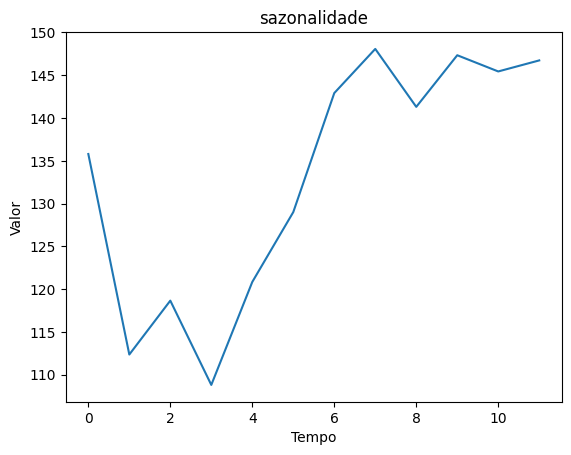

,sazonalidade
sazonalidade,
0,135.794612
1,112.360534
2,118.657694
3,108.808489
4,120.843640
5,129.005874
6,142.915259
7,148.074788
8,141.302597


In [54]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [55]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Ceará - Desemprego,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - PIB - Preços de Mercado,Ceará - IDH Longevidade,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Ceará - Consumo de Cimento (t)
0,2003-1,8.274459,0.655921,0.301376,0.609343,10216.279200,1.434011,1009.566955,2194.226625,27.066062,21.474686,72.364001,3.070554,4.636226e+06,0.684040,6.965352e+07,4.525724e+06,7.532751,6.293821e+07,0.767766,107.673000,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,135.794612,81.265
1,2003-2,8.268512,0.656490,0.301393,0.609740,10302.959969,1.434339,1009.565399,2194.226625,27.066711,21.474876,72.363165,3.069036,4.657223e+06,0.684476,6.974354e+07,4.530359e+06,7.535808,6.297178e+07,0.768211,107.237962,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,112.360534,65.200
2,2003-3,8.262564,0.657059,0.301309,0.610137,10382.029969,1.434531,1009.564492,2194.226625,27.067090,21.474987,72.362677,3.068150,4.678221e+06,0.684912,6.983356e+07,4.534994e+06,7.538865,6.300536e+07,0.768657,108.742184,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,118.657694,55.165
3,2003-4,8.256617,0.657627,0.300917,0.610534,10456.629969,1.434551,1009.564395,2194.226625,27.067131,21.474998,72.362625,3.068055,4.699218e+06,0.685347,6.992358e+07,4.539629e+06,7.541921,6.303893e+07,0.769102,109.391112,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,108.808489,53.928
4,2003-5,8.250670,0.658196,0.300417,0.610931,10527.718245,1.695872,1009.272152,2621.020212,27.009913,21.671734,73.524145,2.951262,4.720215e+06,0.685783,7.001361e+07,4.544265e+06,7.544978,6.307250e+07,0.769547,111.602457,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,120.843640,65.334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,35513.477421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.843640,NaN
245,2023-6,NaN,NaN,NaN,NaN,35482.972969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.005874,NaN
246,2023-7,NaN,NaN,NaN,NaN,35420.342200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142.915259,NaN
247,2023-8,NaN,NaN,NaN,NaN,35331.884078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148.074788,NaN


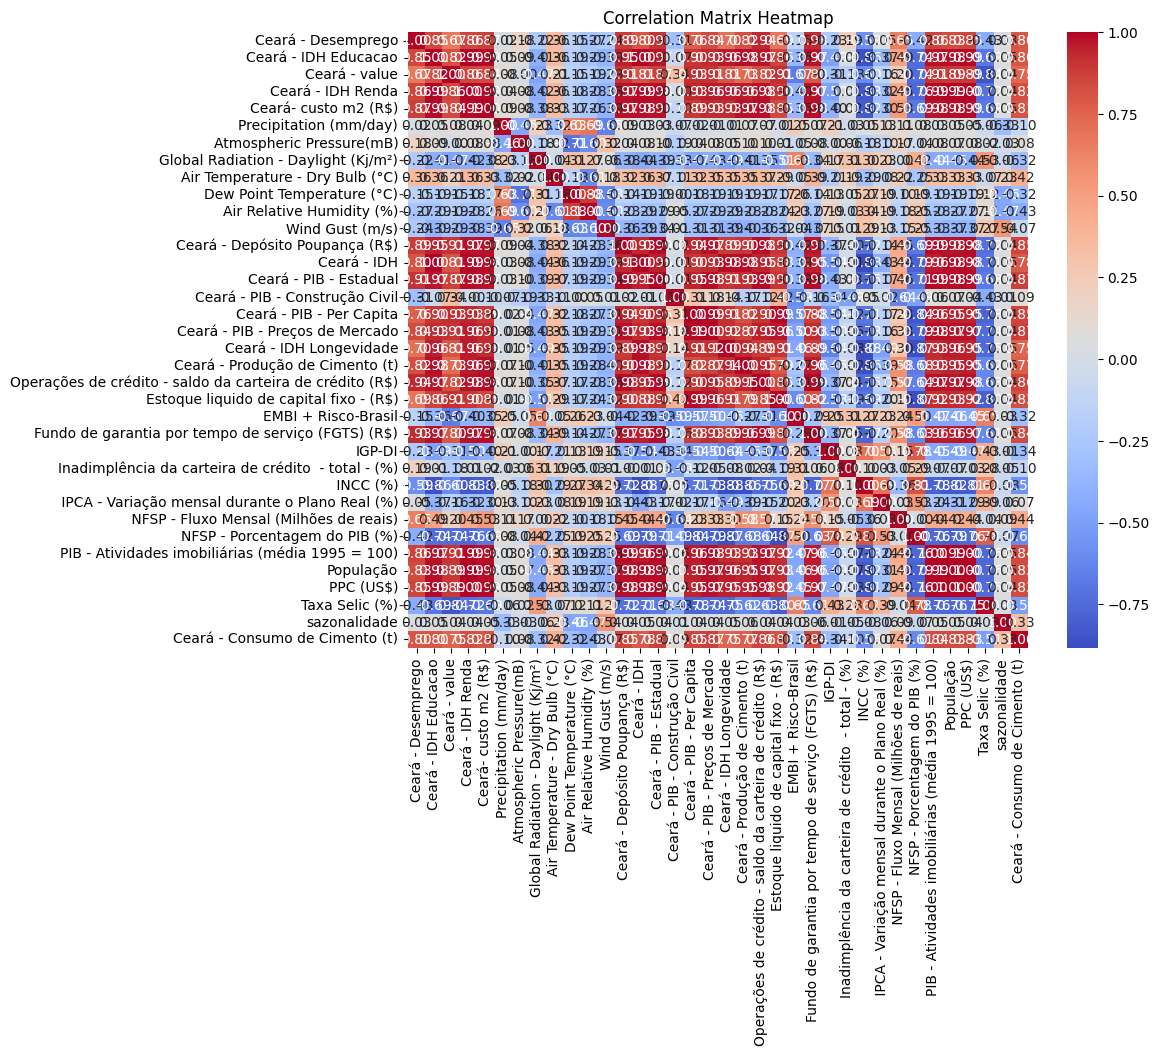

In [56]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [57]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
# data

In [58]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Ceará - Desemprego,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - PIB - Preços de Mercado,Ceará - IDH Longevidade,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-0.777612,-1.869309,-1.446563,-1.915617,-1.591804,-0.308162,0.185125,0.220967,-0.416339,-0.010479,0.121023,0.812339,-1.517043,-2.089980,-1.710320,-1.784591,-2.264453,-2.078282,-2.505791,-1.711278,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,0.192858
1,-0.782340,-1.844778,-1.445945,-1.891034,-1.572601,-0.307589,0.183811,0.220967,-0.414806,-0.010207,0.120802,0.808988,-1.507265,-2.056200,-1.691964,-1.739638,-2.228847,-2.046399,-2.455436,-1.729252,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.488257
2,-0.787067,-1.820247,-1.449072,-1.866452,-1.555084,-0.307255,0.183045,0.220967,-0.413911,-0.010048,0.120673,0.807033,-1.497486,-2.022420,-1.673607,-1.694684,-2.193241,-2.014516,-2.405081,-1.667105,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-1.036511
3,-0.791795,-1.795717,-1.463663,-1.841869,-1.538557,-0.307219,0.182963,0.220967,-0.413815,-0.010031,0.120659,0.806823,-1.487707,-1.988641,-1.655251,-1.649730,-2.157635,-1.982633,-2.354726,-1.640295,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-1.743073
4,-0.796522,-1.771186,-1.482248,-1.817286,-1.522809,0.148513,-0.063775,0.450753,-0.548914,0.271648,0.428292,0.549090,-1.477929,-1.954861,-1.636895,-1.604776,-2.122029,-1.950750,-2.304372,-1.548935,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-0.879696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.062332,1.499030,1.412350,1.344571,1.692758,0.109414,0.565069,-0.220466,-0.018091,-1.147183,-0.835529,0.121010,1.318342,1.416090,1.084593,-1.281134,0.537648,0.738842,1.100599,1.593689,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.073813
188,1.063244,1.497170,1.500856,1.342796,1.712678,0.401538,0.194687,-0.222766,0.365944,-0.896043,-0.827279,0.123083,1.327586,1.410646,1.073027,-1.282511,0.515683,0.720806,1.084871,1.645498,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,0.587990
189,1.064157,1.495311,1.599064,1.341021,1.733250,0.615486,0.042587,-0.246777,0.679715,-0.410313,-0.609153,-0.152425,1.336831,1.405202,1.061462,-1.283888,0.493719,0.702770,1.069142,1.698639,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.020900
190,1.065069,1.493451,1.702017,1.339245,1.756366,0.550554,-0.126340,-0.236873,1.435026,0.175592,-0.525307,-0.355465,1.346076,1.399758,1.049897,-1.285265,0.471754,0.684734,1.053414,1.730727,1.370978,0.332791,-0.169867,1.654237,1.

In [59]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      75.575
1      53.065
2      67.755
3      64.858
4      72.377
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Ceará - Consumo de Cimento (t), Length: 249, dtype: float64

In [60]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Ceará - Desemprego,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - PIB - Preços de Mercado,Ceará - IDH Longevidade,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-0.777612,-1.869309,-1.446563,-1.915617,-1.591804,-0.308162,0.185125,0.220967,-0.416339,-0.010479,0.121023,0.812339,-1.517043,-2.089980,-1.710320,-1.784591,-2.264453,-2.078282,-2.505791,-1.711278,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,0.364808,4.398348,-1.873379,-2.042341,-1.825286,2.132459,0.192858
1,-0.782340,-1.844778,-1.445945,-1.891034,-1.572601,-0.307589,0.183811,0.220967,-0.414806,-0.010207,0.120802,0.808988,-1.507265,-2.056200,-1.691964,-1.739638,-2.228847,-2.046399,-2.455436,-1.729252,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,0.368956,4.222509,-1.868164,-2.014760,-1.813648,1.592202,-1.488257
2,-0.787067,-1.820247,-1.449072,-1.866452,-1.555084,-0.307255,0.183045,0.220967,-0.413911,-0.010048,0.120673,0.807033,-1.497486,-2.022420,-1.673607,-1.694684,-2.193241,-2.014516,-2.405081,-1.667105,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,0.331110,4.026019,-1.862949,-1.987179,-1.801637,2.999926,-1.036511
3,-0.791795,-1.795717,-1.463663,-1.841869,-1.538557,-0.307219,0.182963,0.220967,-0.413815,-0.010031,0.120659,0.806823,-1.487707,-1.988641,-1.655251,-1.649730,-2.157635,-1.982633,-2.354726,-1.640295,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,0.244570,3.811492,-1.857734,-1.959598,-1.789347,1.273293,-1.743073
4,-0.796522,-1.771186,-1.482248,-1.817286,-1.522809,0.148513,-0.063775,0.450753,-0.548914,0.271648,0.428292,0.549090,-1.477929,-1.954861,-1.636895,-1.604776,-2.122029,-1.950750,-2.304372,-1.548935,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,0.279013,3.567576,-1.851305,-1.932017,-1.777381,2.045407,-0.879696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.423186,1.361249,-0.021469,1.302738,1.118138,-0.010814,0.041354,-0.188518,3.009262,1.041224,-0.576167,-1.275706,0.835910,1.409954,1.190773,-0.838130,0.874129,1.017258,1.442520,1.523635,1.335787,0.819304,0.961603,1.338424,-1.233012,0.749349,-0.883659,-0.214006,1.216560,-0.607704,0.952667,1.031384,1.044043,0.043807,-1.488257
158,1.399318,1.368648,-0.031468,1.304757,1.138940,0.120633,0.304122,-0.225452,2.843253,0.890818,-0.599064,-2.535161,0.857843,1.414132,1.193287,-0.881990,0.871719,1.015919,1.434604,1.541381,1.325546,0.808136,1.030624,1.300351,-1.299304,0.977327,-0.950771,-0.434717,1.155373,-0.620523,0.954843,1.042716,1.056960,0.210856,-1.036511
159,1.375451,1.376047,-0.044253,1.306776,1.160380,-0.530269,0.571970,-0.233685,2.364135,0.359401,-0.770590,-2.850455,0.879775,1.418310,1.195800,-0.925849,0.869309,1.014581,1.426687,1.523536,1.315396,0.796969,1.039183,1.250508,-1.248662,1.048267,-1.028465,-0.524091,1.056140,-0.631530,0.957019,1.054049,1.070172,0.107070,-1.743073
160,1.351584,1.383446,-0.046806,1.308795,1.181921,-0.838306,1.017351,-0.205686,2.115134,-0.381258,-1.211611,-2.417126,0.901707,1.422488,1.198313,-0.969709,0.866899,1.013242,1.418771,1.507028,1.306664,0.785801,1.017171,1.240363,-

In [61]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       75.575
1       53.065
2       67.755
3       64.858
4       72.377
        ...   
157    134.739
158    151.819
159    124.858
160    162.684
161    169.251
Name: Ceará - Consumo de Cimento (t), Length: 162, dtype: float64

In [62]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [63]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 35)

In [64]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Ceará - Desemprego,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - PIB - Preços de Mercado,Ceará - IDH Longevidade,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
126,0.941464,0.425889,1.223482,0.655769,0.483847,-0.480018,0.646504,-0.248992,-0.309701,-0.286801,-0.041850,0.421468,1.016871,0.365676,0.843485,0.634116,1.037548,1.010785,0.321062,0.074200,0.722924,0.944085,-0.882533,0.551812,-0.368821,-0.155884,0.045243,0.888984,-0.230612,-0.460555,0.913820,0.651397,0.697312,-1.048761,0.703679
127,0.969984,0.438004,1.232594,0.656960,0.502516,-0.828855,0.343125,-0.217350,0.124310,-0.600450,-0.514570,1.036869,1.044579,0.371209,0.863067,0.604648,1.047639,1.024388,0.314857,0.100668,0.745258,0.947319,-0.815413,0.566622,-0.328087,-0.349984,0.061828,0.954254,-0.156322,-0.440372,0.923198,0.664707,0.706933,-0.649312,1.073813
128,0.998504,0.450119,1.233295,0.658150,0.521687,-1.004415,0.115828,-0.198600,0.483007,-0.631922,-0.721738,1.220308,1.072288,0.376742,0.882650,0.575180,1.057730,1.037991,0.308653,0.116036,0.767990,0.950553,-0.745839,0.568617,-0.176031,-0.529294,0.046225,1.045217,-0.120008,-0.419247,0.932576,0.678017,0.715675,-0.535369,0.587990
129,1.027024,0.462235,1.227338,0.659341,0.540508,-1.049285,-0.154103,-0.202417,0.761610,-0.465106,-0.736611,1.147966,1.099997,0.382275,0.902233,0.545712,1.067821,1.051594,0.302449,0.134124,0.799035,0.953786,-0.687348,0.719776,-0.113037,-0.788101,0.032522,1.176395,-0.143194,-0.397019,0.941953,0.691327,0.723490,-1.288807,1.020900
130,1.055544,0.474350,1.232230,0.660532,0.558478,-1.026862,-0.507810,-0.230512,0.789801,-0.019451,-0.411043,0.864373,1.127705,0.387808,0.921816,0.516244,1.077913,1.065197,0.296245,0.158476,0.830824,0.957020,-0.639220,0.905478,-0.022703,-1.020394,0.042757,1.303259,-0.028712,-0.376532,0.942711,0.704637,0.730579,-1.507550,0.884965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.062332,1.499030,1.412350,1.344571,1.692758,0.109414,0.565069,-0.220466,-0.018091,-1.147183,-0.835529,0.121010,1.318342,1.416090,1.084593,-1.281134,0.537648,0.738842,1.100599,1.593689,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,2.953658,-0.572934,1.406756,1.365911,1.413217,-1.311366,1.073813
188,1.063244,1.497170,1.500856,1.342796,1.712678,0.401538,0.194687,-0.222766,0.365944,-0.896043,-0.827279,0.123083,1.327586,1.410646,1.073027,-1.282511,0.515683,0.720806,1.084871,1.645498,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,3.351323,-0.588777,1.428132,1.376610,1.425045,-1.417143,0.587990
189,1.064157,1.495311,1.599064,1.341021,1.733250,0.615486,0.042587,-0.246777,0.679715,-0.410313,-0.609153,-0.152425,1.336831,1.405202,1.061462,-1.283888,0.493719,0.702770,1.069142,1.698639,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,3.404908,-0.612606,1.449507,1.387308,1.436067,-1.597784,1.020900
190,1.065069,1.493451,1.702017,1.339245,1.756366,0.550554,-0.126340,-0.236873,1.435026,0.175592,-0.525307,-0.355465,1.346076,1.399758,1.049897,-1.285265,0.471754,0.684734,1.053414,1.730727,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,-1.727496,3.671303,-0.64095

In [65]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 35)

In [66]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [67]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(360, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180, return_sequences=True, activation='tanh'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(36, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [68]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(100)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [69]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2785499098, 397522154, 886443767, 3545164508, 863638585, 644524491, 768353969, 3542998209, 3088700746, 3875734874, 2352695386, 2224230070, 1440785734, 3496175519, 3903359020, 1558835559, 3244636879, 816327409, 3046563767, 1893655263, 1044785497, 4114315900, 2307370768, 4008080139, 832179595, 816067597, 2006686590, 3122728595, 3332770428, 3632028930, 624051217, 1937899244, 3171420027, 3817547933, 752754506, 57296916, 2696501037, 2178057295, 2109584244, 2391352877, 3031801715, 1265050949, 2116896048, 1468531602, 1512973557, 1556006122, 1701421175, 4063105596, 3520572991, 1602374668, 2728563259, 2562996642, 2392530723, 1804331887, 1718834850, 2960487587, 4094945736, 1943227203, 3453997310, 2835630556, 2458722473, 2531564156, 2173983476, 2243981564, 2409276499, 3996177627, 1545615642, 3638708919, 2376968934, 1703598824, 3337642280, 2470226580, 3722416635, 223438221, 1117214325, 457437260, 1853112159, 1876991791, 1345685390, 3582574938, 3481161434, 2910515170, 4004501795, 1704748064, 57582

val_loss: 166.5851593017578


Step: 84 ___________________________________________
val_loss: 154.67100524902344


Step: 85 ___________________________________________
val_loss: 158.79351806640625


Step: 86 ___________________________________________
val_loss: 131.8076629638672


Step: 87 ___________________________________________
val_loss: 357.257080078125


Step: 88 ___________________________________________
val_loss: 92.94277954101562


Step: 89 ___________________________________________
val_loss: 175.55169677734375


Step: 90 ___________________________________________
val_loss: 276.0976867675781


Step: 91 ___________________________________________
val_loss: 156.39295959472656


Step: 92 ___________________________________________
val_loss: 148.14295959472656


Step: 93 ___________________________________________
val_loss: 181.7102508544922


Step: 94 ___________________________________________
val_loss: 165.15203857421875


Step: 95 ___________________________________________

In [70]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 168ms/step - loss: 24065.7051 - val_loss: 13588.3945
Epoch 2/10000
4/4 [==============================] - 0s 12ms/step - loss: 7144.1782 - val_loss: 2241.6494
Epoch 3/10000
4/4 [==============================] - 0s 12ms/step - loss: 2042.4584 - val_loss: 1841.3605
Epoch 4/10000
4/4 [==============================] - 0s 13ms/step - loss: 1960.8318 - val_loss: 1856.7916
Epoch 5/10000
4/4 [==============================] - 0s 12ms/step - loss: 1967.8954 - val_loss: 1864.8064
Epoch 6/10000
4/4 [==============================] - 0s 12ms/step - loss: 2513.5374 - val_loss: 1528.6646
Epoch 7/10000
4/4 [==============================] - 0s 14ms/step - loss: 1443.5759 - val_loss: 1644.3590
Epoch 8/10000
4/4 [==============================] - 0s 13ms/step - loss: 1540.3378 - val_loss: 1232.2258
Epoch 9/10000
4/4 [==============================] - 0s 12ms/step - loss: 1298.3231 - val_loss: 1221.5413
Epoch 10/10000
4/4 [=======================

Epoch 79/10000
4/4 [==============================] - 0s 12ms/step - loss: 516.8681 - val_loss: 525.7347
Epoch 80/10000
4/4 [==============================] - 0s 12ms/step - loss: 490.8112 - val_loss: 602.2812
Epoch 81/10000
4/4 [==============================] - 0s 13ms/step - loss: 550.1163 - val_loss: 536.6951
Epoch 82/10000
4/4 [==============================] - 0s 11ms/step - loss: 542.7853 - val_loss: 483.5660
Epoch 83/10000
4/4 [==============================] - 0s 12ms/step - loss: 489.7273 - val_loss: 497.3854
Epoch 84/10000
4/4 [==============================] - 0s 13ms/step - loss: 487.1002 - val_loss: 529.8376
Epoch 85/10000
4/4 [==============================] - 0s 14ms/step - loss: 513.2836 - val_loss: 489.5573
Epoch 86/10000
4/4 [==============================] - 0s 12ms/step - loss: 481.2200 - val_loss: 499.2962
Epoch 87/10000
4/4 [==============================] - 0s 12ms/step - loss: 514.4864 - val_loss: 482.0688
Epoch 88/10000
4/4 [==============================] - 0

4/4 [==============================] - 0s 11ms/step - loss: 283.5425 - val_loss: 317.3265
Epoch 157/10000
4/4 [==============================] - 0s 11ms/step - loss: 284.7106 - val_loss: 501.0200
Epoch 158/10000
4/4 [==============================] - 0s 11ms/step - loss: 373.3945 - val_loss: 408.8871
Epoch 159/10000
4/4 [==============================] - 0s 12ms/step - loss: 299.6896 - val_loss: 406.0193
Epoch 160/10000
4/4 [==============================] - 0s 13ms/step - loss: 281.9049 - val_loss: 392.7246
Epoch 161/10000
4/4 [==============================] - 0s 12ms/step - loss: 264.7581 - val_loss: 316.2344
Epoch 162/10000
4/4 [==============================] - 0s 12ms/step - loss: 246.3921 - val_loss: 369.3815
Epoch 163/10000
4/4 [==============================] - 0s 12ms/step - loss: 300.0608 - val_loss: 362.1550
Epoch 164/10000
4/4 [==============================] - 0s 11ms/step - loss: 326.9582 - val_loss: 405.3096
Epoch 165/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 11ms/step - loss: 186.2363 - val_loss: 312.0660
Epoch 234/10000
4/4 [==============================] - 0s 12ms/step - loss: 146.9775 - val_loss: 280.3807
Epoch 235/10000
4/4 [==============================] - 0s 12ms/step - loss: 177.9290 - val_loss: 322.2660
Epoch 236/10000
4/4 [==============================] - 0s 13ms/step - loss: 238.3459 - val_loss: 265.2130
Epoch 237/10000
4/4 [==============================] - 0s 12ms/step - loss: 175.5837 - val_loss: 205.7011
Epoch 238/10000
4/4 [==============================] - 0s 11ms/step - loss: 192.3033 - val_loss: 234.7256
Epoch 239/10000
4/4 [==============================] - 0s 11ms/step - loss: 167.2633 - val_loss: 246.4235
Epoch 240/10000
4/4 [==============================] - 0s 11ms/step - loss: 201.2525 - val_loss: 347.4633
Epoch 241/10000
4/4 [==============================] - 0s 12ms/step - loss: 217.6686 - val_loss: 247.9284
Epoch 242/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 12ms/step - loss: 137.3734 - val_loss: 208.7976
Epoch 311/10000
4/4 [==============================] - 0s 12ms/step - loss: 153.6703 - val_loss: 215.5999
Epoch 312/10000
4/4 [==============================] - 0s 12ms/step - loss: 118.8544 - val_loss: 224.8161
Epoch 313/10000
4/4 [==============================] - 0s 11ms/step - loss: 130.9705 - val_loss: 232.7548
Epoch 314/10000
4/4 [==============================] - 0s 11ms/step - loss: 108.2866 - val_loss: 216.2147
Epoch 315/10000
4/4 [==============================] - 0s 12ms/step - loss: 128.1892 - val_loss: 773.2404
Epoch 316/10000
4/4 [==============================] - 0s 11ms/step - loss: 341.2645 - val_loss: 242.3320
Epoch 317/10000
4/4 [==============================] - 0s 12ms/step - loss: 159.6252 - val_loss: 182.2313
Epoch 318/10000
4/4 [==============================] - 0s 13ms/step - loss: 147.2632 - val_loss: 263.9165
Epoch 319/10000
4/4 [==============================] - 0s 13ms

4/4 [==============================] - 0s 14ms/step - loss: 107.4260 - val_loss: 216.1236
Epoch 388/10000
4/4 [==============================] - 0s 12ms/step - loss: 121.3771 - val_loss: 275.3326
Epoch 389/10000
4/4 [==============================] - 0s 14ms/step - loss: 128.5837 - val_loss: 178.9087
Epoch 390/10000
4/4 [==============================] - 0s 11ms/step - loss: 121.8475 - val_loss: 306.7691
Epoch 391/10000
4/4 [==============================] - 0s 12ms/step - loss: 134.2454 - val_loss: 228.3794
Epoch 392/10000
4/4 [==============================] - 0s 11ms/step - loss: 110.0496 - val_loss: 271.2003
Epoch 393/10000
4/4 [==============================] - 0s 11ms/step - loss: 110.7436 - val_loss: 204.1453
Epoch 394/10000
4/4 [==============================] - 0s 12ms/step - loss: 93.2857 - val_loss: 228.1837
Epoch 395/10000
4/4 [==============================] - 0s 12ms/step - loss: 108.7696 - val_loss: 195.9354
Epoch 396/10000
4/4 [==============================] - 0s 13ms/

4/4 [==============================] - 0s 11ms/step - loss: 88.4227 - val_loss: 312.9936
Epoch 465/10000
4/4 [==============================] - 0s 11ms/step - loss: 99.0904 - val_loss: 179.3563
Epoch 466/10000
4/4 [==============================] - 0s 13ms/step - loss: 93.7278 - val_loss: 260.1520
Epoch 467/10000
4/4 [==============================] - 0s 12ms/step - loss: 88.6834 - val_loss: 142.5938
Epoch 468/10000
4/4 [==============================] - 0s 13ms/step - loss: 86.5900 - val_loss: 226.6654
Epoch 469/10000
4/4 [==============================] - 0s 12ms/step - loss: 98.5547 - val_loss: 241.9037
Epoch 470/10000
4/4 [==============================] - 0s 11ms/step - loss: 91.3083 - val_loss: 298.7528
Epoch 471/10000
4/4 [==============================] - 0s 11ms/step - loss: 92.5032 - val_loss: 320.1450
Epoch 472/10000
4/4 [==============================] - 0s 13ms/step - loss: 94.3092 - val_loss: 246.9724
Epoch 473/10000
4/4 [==============================] - 0s 14ms/step - l

4/4 [==============================] - 0s 12ms/step - loss: 99.7784 - val_loss: 239.4417
Epoch 543/10000
4/4 [==============================] - 0s 12ms/step - loss: 72.4307 - val_loss: 122.1578
Epoch 544/10000
4/4 [==============================] - 0s 13ms/step - loss: 119.7993 - val_loss: 279.7995
Epoch 545/10000
4/4 [==============================] - 0s 12ms/step - loss: 90.0273 - val_loss: 244.3032
Epoch 546/10000
4/4 [==============================] - 0s 11ms/step - loss: 92.7141 - val_loss: 173.5462
Epoch 547/10000
4/4 [==============================] - 0s 11ms/step - loss: 70.3173 - val_loss: 205.4113
Epoch 548/10000
4/4 [==============================] - 0s 12ms/step - loss: 75.0813 - val_loss: 242.4317
Epoch 549/10000
4/4 [==============================] - 0s 12ms/step - loss: 80.6158 - val_loss: 205.0583
Epoch 550/10000
4/4 [==============================] - 0s 12ms/step - loss: 81.4604 - val_loss: 248.1729
Epoch 551/10000
4/4 [==============================] - 0s 13ms/step - 

4/4 [==============================] - 0s 11ms/step - loss: 59.9837 - val_loss: 281.0124
Epoch 621/10000
4/4 [==============================] - 0s 11ms/step - loss: 73.3685 - val_loss: 330.2813
Epoch 622/10000
4/4 [==============================] - 0s 11ms/step - loss: 72.6661 - val_loss: 408.6521
Epoch 623/10000
4/4 [==============================] - 0s 12ms/step - loss: 112.2221 - val_loss: 299.3681
Epoch 624/10000
4/4 [==============================] - 0s 12ms/step - loss: 77.9778 - val_loss: 251.3063
Epoch 625/10000
4/4 [==============================] - 0s 12ms/step - loss: 77.0722 - val_loss: 270.6981
Epoch 626/10000
4/4 [==============================] - 0s 12ms/step - loss: 81.5615 - val_loss: 292.8251
Epoch 627/10000
4/4 [==============================] - 0s 11ms/step - loss: 78.1012 - val_loss: 283.4155
Epoch 628/10000
4/4 [==============================] - 0s 12ms/step - loss: 74.4596 - val_loss: 198.9834
Epoch 629/10000
4/4 [==============================] - 0s 11ms/step - 

4/4 [==============================] - 0s 12ms/step - loss: 77.4760 - val_loss: 139.8075
Epoch 699/10000
4/4 [==============================] - 0s 12ms/step - loss: 65.7456 - val_loss: 144.1697
Epoch 700/10000
4/4 [==============================] - 0s 12ms/step - loss: 85.2716 - val_loss: 391.5635
Epoch 701/10000
4/4 [==============================] - 0s 12ms/step - loss: 119.7556 - val_loss: 257.5303
Epoch 702/10000
4/4 [==============================] - 0s 12ms/step - loss: 76.8135 - val_loss: 289.5760
Epoch 703/10000
4/4 [==============================] - 0s 12ms/step - loss: 72.8591 - val_loss: 298.2578
Epoch 704/10000
4/4 [==============================] - 0s 11ms/step - loss: 69.2061 - val_loss: 246.8872
Epoch 705/10000
4/4 [==============================] - 0s 11ms/step - loss: 70.4278 - val_loss: 258.8715
Epoch 706/10000
4/4 [==============================] - 0s 13ms/step - loss: 52.0422 - val_loss: 230.1100
Epoch 707/10000
4/4 [==============================] - 0s 13ms/step - 

4/4 [==============================] - 0s 13ms/step - loss: 48.6404 - val_loss: 138.5624
Epoch 777/10000
4/4 [==============================] - 0s 12ms/step - loss: 56.4865 - val_loss: 169.9178
Epoch 778/10000
4/4 [==============================] - 0s 11ms/step - loss: 43.5585 - val_loss: 138.9152
Epoch 779/10000
4/4 [==============================] - 0s 11ms/step - loss: 51.7846 - val_loss: 160.5494
Epoch 780/10000
4/4 [==============================] - 0s 12ms/step - loss: 38.2577 - val_loss: 246.9077
Epoch 781/10000
4/4 [==============================] - 0s 13ms/step - loss: 57.3308 - val_loss: 198.4455
Epoch 782/10000
4/4 [==============================] - 0s 13ms/step - loss: 45.7408 - val_loss: 258.3606
Epoch 783/10000
4/4 [==============================] - 0s 14ms/step - loss: 55.2673 - val_loss: 149.0081
Epoch 784/10000
4/4 [==============================] - 0s 13ms/step - loss: 46.6833 - val_loss: 185.2880
Epoch 785/10000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 12ms/step - loss: 44.5560 - val_loss: 279.2076
Epoch 855/10000
4/4 [==============================] - 0s 12ms/step - loss: 41.7834 - val_loss: 218.9724
Epoch 856/10000
4/4 [==============================] - 0s 12ms/step - loss: 33.5085 - val_loss: 223.7677
Epoch 857/10000
4/4 [==============================] - 0s 13ms/step - loss: 35.8188 - val_loss: 189.4343
Epoch 858/10000
4/4 [==============================] - 0s 12ms/step - loss: 39.3049 - val_loss: 190.2253
Epoch 859/10000
4/4 [==============================] - 0s 12ms/step - loss: 40.9044 - val_loss: 129.2119
Epoch 860/10000
4/4 [==============================] - 0s 11ms/step - loss: 72.5462 - val_loss: 205.5128
Epoch 861/10000
4/4 [==============================] - 0s 12ms/step - loss: 42.9515 - val_loss: 125.5043
Epoch 862/10000
4/4 [==============================] - 0s 12ms/step - loss: 45.8764 - val_loss: 186.4471
Epoch 863/10000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 12ms/step - loss: 60.1446 - val_loss: 118.9504
Epoch 933/10000
4/4 [==============================] - 0s 12ms/step - loss: 53.0346 - val_loss: 184.3080
Epoch 934/10000
4/4 [==============================] - 0s 13ms/step - loss: 47.6769 - val_loss: 111.4034
Epoch 935/10000
4/4 [==============================] - 0s 12ms/step - loss: 53.8933 - val_loss: 135.1841
Epoch 936/10000
4/4 [==============================] - 0s 11ms/step - loss: 58.1384 - val_loss: 136.1801
Epoch 937/10000
4/4 [==============================] - 0s 11ms/step - loss: 53.8729 - val_loss: 232.4274
Epoch 938/10000
4/4 [==============================] - 0s 12ms/step - loss: 49.3125 - val_loss: 229.2431
Epoch 939/10000
4/4 [==============================] - 0s 12ms/step - loss: 50.2070 - val_loss: 263.7673
Epoch 940/10000
4/4 [==============================] - 0s 12ms/step - loss: 43.5657 - val_loss: 237.6377
Epoch 941/10000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 12ms/step - loss: 44.1532 - val_loss: 141.4429
Epoch 1011/10000
4/4 [==============================] - 0s 13ms/step - loss: 44.1402 - val_loss: 188.7615
Epoch 1012/10000
4/4 [==============================] - 0s 12ms/step - loss: 31.2561 - val_loss: 111.4712
Epoch 1013/10000
4/4 [==============================] - 0s 11ms/step - loss: 33.2802 - val_loss: 176.3464
Epoch 1014/10000
4/4 [==============================] - 0s 12ms/step - loss: 35.9956 - val_loss: 298.0140
Epoch 1015/10000
4/4 [==============================] - 0s 12ms/step - loss: 44.2885 - val_loss: 234.2369
Epoch 1016/10000
4/4 [==============================] - 0s 12ms/step - loss: 35.9392 - val_loss: 257.8845
Epoch 1017/10000
4/4 [==============================] - 0s 12ms/step - loss: 38.4791 - val_loss: 107.2862
Epoch 1018/10000
4/4 [==============================] - 0s 13ms/step - loss: 37.5209 - val_loss: 152.9097
Epoch 1019/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 12ms/step - loss: 29.9790 - val_loss: 225.1776
Epoch 1088/10000
4/4 [==============================] - 0s 12ms/step - loss: 40.3082 - val_loss: 164.1435
Epoch 1089/10000
4/4 [==============================] - 0s 13ms/step - loss: 34.9569 - val_loss: 124.5211
Epoch 1090/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.1200 - val_loss: 144.2977
Epoch 1091/10000
4/4 [==============================] - 0s 11ms/step - loss: 34.2552 - val_loss: 136.7651
Epoch 1092/10000
4/4 [==============================] - 0s 11ms/step - loss: 36.7964 - val_loss: 143.8504
Epoch 1093/10000
4/4 [==============================] - 0s 11ms/step - loss: 34.3795 - val_loss: 151.2816
Epoch 1094/10000
4/4 [==============================] - 0s 12ms/step - loss: 50.9836 - val_loss: 163.4921
Epoch 1095/10000
4/4 [==============================] - 0s 12ms/step - loss: 46.7870 - val_loss: 142.3156
Epoch 1096/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 12ms/step - loss: 35.8722 - val_loss: 214.4766
Epoch 1165/10000
4/4 [==============================] - 0s 12ms/step - loss: 25.1897 - val_loss: 277.7392
Epoch 1166/10000
4/4 [==============================] - 0s 12ms/step - loss: 30.9715 - val_loss: 219.7630
Epoch 1167/10000
4/4 [==============================] - 0s 12ms/step - loss: 39.0185 - val_loss: 189.8032
Epoch 1168/10000
4/4 [==============================] - 0s 11ms/step - loss: 24.7122 - val_loss: 263.1103
Epoch 1169/10000
4/4 [==============================] - 0s 12ms/step - loss: 38.1044 - val_loss: 242.2448
Epoch 1170/10000
4/4 [==============================] - 0s 12ms/step - loss: 26.5183 - val_loss: 184.5338
Epoch 1171/10000
4/4 [==============================] - 0s 12ms/step - loss: 29.4614 - val_loss: 125.7836
Epoch 1172/10000
4/4 [==============================] - 0s 12ms/step - loss: 32.6456 - val_loss: 189.1799
Epoch 1173/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 11ms/step - loss: 28.3781 - val_loss: 197.8563
Epoch 1242/10000
4/4 [==============================] - 0s 12ms/step - loss: 25.3356 - val_loss: 305.4451
Epoch 1243/10000
4/4 [==============================] - 0s 12ms/step - loss: 25.1428 - val_loss: 207.0247
Epoch 1244/10000
4/4 [==============================] - 0s 12ms/step - loss: 25.4759 - val_loss: 206.5162
Epoch 1245/10000
4/4 [==============================] - 0s 12ms/step - loss: 21.5189 - val_loss: 171.4120
Epoch 1246/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.8705 - val_loss: 159.8721
Epoch 1247/10000
4/4 [==============================] - 0s 12ms/step - loss: 36.7531 - val_loss: 128.9762
Epoch 1248/10000
4/4 [==============================] - 0s 12ms/step - loss: 29.5069 - val_loss: 187.2182
Epoch 1249/10000
4/4 [==============================] - 0s 12ms/step - loss: 26.7452 - val_loss: 155.2941
Epoch 1250/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 13ms/step - loss: 18.3023 - val_loss: 214.0925
Epoch 1319/10000
4/4 [==============================] - 0s 12ms/step - loss: 23.6475 - val_loss: 193.3059
Epoch 1320/10000
4/4 [==============================] - 0s 11ms/step - loss: 23.9145 - val_loss: 221.6428
Epoch 1321/10000
4/4 [==============================] - 0s 11ms/step - loss: 25.7028 - val_loss: 204.5676
Epoch 1322/10000
4/4 [==============================] - 0s 12ms/step - loss: 22.5134 - val_loss: 181.6854
Epoch 1323/10000
4/4 [==============================] - 0s 12ms/step - loss: 25.8016 - val_loss: 219.3730
Epoch 1324/10000
4/4 [==============================] - 0s 12ms/step - loss: 23.2326 - val_loss: 146.8948
Epoch 1325/10000
4/4 [==============================] - 0s 12ms/step - loss: 21.8987 - val_loss: 195.5723
Epoch 1326/10000
4/4 [==============================] - 0s 12ms/step - loss: 19.5312 - val_loss: 191.6855
Epoch 1327/10000
4/4 [==============================] - 0s 12ms

In [71]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [72]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,188.367798,199.365326,193.286331,188.708542,185.455429,158.124039,148.231339,148.231491,148.233597,148.233353,148.236588,148.245026,151.264313,185.67894,185.359451,185.205902,181.163391,148.3965,148.231705,148.231918,148.234711,148.236969,148.241653,148.245956,154.583725,183.627029,183.845718,177.671494,149.273178,148.242691
Target,179.243,194.134,186.948,194.907,179.505,173.278,160.261,113.987,114.289,117.313,110.502,147.996,152.386,177.259,155.913,172.41,179.419,157.165,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,9.124802,5.231323,6.338333,6.198456,5.950424,15.153961,12.029663,34.244492,33.944595,30.920349,37.734589,0.249023,1.121689,8.419937,29.446457,12.795898,1.744385,8.768494,3.369293,18.694916,42.998711,37.40197,20.31665,21.107956,2.544281,19.187027,43.547714,9.264496,14.341827,6.827316


In [73]:
display(mae)
display(mape)

16.633968

0.12647514

In [74]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [75]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-0: |Prediction[[2002.7189]] - Target[1872.363]| =  Error: [[130.35583]]; MAPE:[[0.06962103]]
1/1 [==============================] - 0s 14ms/step
Ano-0: |Prediction[[1926.4915]] - Target[1746.8239999999998]| =  Error: [[179.66748]]; MAPE:[[0.1028538]]
1/1 [==============================] - 0s 14ms/step
Ano-5: |Prediction[[997.24384]] - Target[948.9580000000001]| =  Error: [[48.285828]]; MAPE:[[0.050883]]


[array([[130.35583]], dtype=float32),
 array([[179.66748]], dtype=float32),
 array([[48.285828]], dtype=float32)]

119.43638

0.07445261